In [1]:
import numpy as np
import pandas as pd
import math
import datetime as dt
import datapackage
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multinomial
from typing import List
import seaborn as sns
import ROVfxns as ROV

## system characterisation

M = 4
N = 4

state_1 = ROV.State(1.48, 0.05, 0.02, 0.024)
state_2 = ROV.State(4.58, 0.05, 0.0095, 0.11)

T = 30
E = 10000000
r = 0.015
vc = 1
fc = 10000
pi_tax = 0.28
c_tax = 1

# lattice parameters ##

s0_step = 20000000

p_1 = 0.5
p_max = 8

s0_1 = 800000000
s0_max = 1300000000

# lattice construction #

##
p_lower = np.linspace(0.75,1.75,3)
p_centre = np.linspace(2,6,17)
p_high = np.linspace(6.5,9,6)
p_higher = np.array(12)

P_grid = np.append(p_lower,p_centre) 
P_grid = np.append(P_grid,p_high)
P_grid = np.append(P_grid,p_higher)
P_grid = P_grid.tolist()

print(P_grid)

s0_grid = list(range(s0_1, s0_max, s0_step))

S = 2
temp_node = np.full((S,len(P_grid), len(s0_grid), M, N), 0)
node_value = np.full((S,len(P_grid), len(s0_grid), M, N), 0)
Lv = np.full((S,len(P_grid), len(s0_grid), M, N), 0)

# here we store the optimal state n in N conditional on prior state m in M ##

temp_path = np.full((S,len(P_grid), len(s0_grid), M), 0)
temp_path_1 = np.full((S,len(P_grid), len(s0_grid), M), 0)
opt_path = []

cost = np.zeros((M, N))
temp_compare = np.zeros((N))

opt_path = np.full((T,S,len(P_grid), len(s0_grid), M), 0)

## cost of staying in or returning to pre-construction state ##

cost[0, 0] = 0
cost[1, 0] = 15000000
cost[2, 0] = 15000000
cost[3, 0] = 15000000

## cost of staying in or moving to operational ##

cost[0, 1] = 70000
cost[1, 1] = 0
cost[2, 1] = 100000000
cost[3, 1] = 100000000

## cost of staying in moving to or returning to mothball ##

cost[0, 2] = 150000000
cost[1, 2] = 200000
cost[2, 2] = 0
cost[3, 2] = 25000000

## cost of moving to abandoned state ##

cost[0, 3] = 100000000
cost[1, 3] = 100000000
cost[2, 3] = 1000000
cost[3, 3] = 0

[0.75, 1.25, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 12.0]


In [2]:
for t in range(T):
    for q in range(4):

## M refers to adjacent state, N refers to current state ##

## Quarterly profit at each node ##
        for s in range(2):
            for i in range(len(P_grid)):
                for k in range(len(s0_grid)):
                    for m in range(M):
                        for n in range(N):
                            if n == 1:
                                if (T*4 - (t*4 + q))*E < s0_grid[k]:
                                    temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] + ROV.Profit(E,P_grid[i],vc,fc,pi_tax,c_tax)
                                else:
                                    temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] - fc
                            else:
                                temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] - fc

## Lagrange Differential at each node ##

## then we loop over lagrange differential for nodes inside the boundary ##
        for s in range(2):
            for i in range(1,len(P_grid) - 1):
                for k in range(len(s0_grid)):
                    for m in range(M):
                        for n in range(N):
                            if s == 0:
                                diff = ROV.difference(P_grid[i],P_grid[i-1],P_grid[i+1],state_1.s,state_1.e,state_1.m)
                                Lv[s,i,k,m,n] = diff[0]*temp_node[s,i - 1,k,m,n] + diff[1]*temp_node[s,i + 1,k,m,n] - (diff[0]+diff[1]+r)*temp_node[s,i,k,m,n] + state_1.l*(temp_node[0,i,k,m,n]-temp_node[1,i,k,m,n])
                            else:
                                diff = ROV.difference(P_grid[i],P_grid[i-1],P_grid[i+1],state_1.s,state_1.e,state_1.m)
                                Lv[s,i,k,m,n] = diff[0]*temp_node[s,i - 1,k,m,n] + diff[1]*temp_node[s,i + 1,k,m,n] - (diff[0]+diff[1]+r)*temp_node[s,i,k,m,n] + state_2.l*(temp_node[1,i,k,m,n]-temp_node[0,i,k,m,n])

## we loop over Lagrange differential for boundary nodes ##

        for s in range(2):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        if s == 0:
                            diff = ROV.difference_min(P_grid[0],(P_grid[1]-P_grid[0]),state_1.e,state_1.m)
                            Lv[s,0,k,m,n] = diff[1]*temp_node[s,1,k,m,n] - (diff[1]+r)*temp_node[s,0,k,m,n] + state_1.l*(temp_node[0,0,k,m,n]-temp_node[1,0,k,m,n])
                        else:
                            diff = ROV.difference_min(P_grid[0],(P_grid[1]-P_grid[0]),state_2.e,state_2.m)
                            Lv[s,0,k,m,n] = diff[1]*temp_node[s,1,k,m,n] - (diff[1]+r)*temp_node[s,0,k,m,n] + state_2.l*(temp_node[1,0,k,m,n]-temp_node[0,0,k,m,n])

        for s in range(2):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        if s == 0:
                            diff = ROV.difference_max(P_grid[len(P_grid)-1],(P_grid[len(P_grid)-1]-P_grid[len(P_grid)-2]),state_1.e,state_1.m)
                            Lv[s,len(P_grid) - 1,k,m,n] = diff[0]*temp_node[s,len(P_grid)-2,k,m,n] - (diff[0]+r)*temp_node[s,len(P_grid)-1,k,m,n] + state_1.l*(temp_node[0,len(P_grid) - 1,k,m,n]-temp_node[1,len(P_grid) - 1,k,m,n])
                        else:
                            diff = ROV.difference_max(P_grid[len(P_grid)-1],(P_grid[len(P_grid)-1]-P_grid[len(P_grid)-2]),state_2.e,state_2.m)
                            Lv[s,len(P_grid) - 1,k,m,n] = diff[0]*temp_node[s,len(P_grid)-2,k,m,n] - (diff[0]+r)*temp_node[s,len(P_grid)-1,k,m,n] + state_2.l*(temp_node[1,len(P_grid) - 1,k,m,n]-temp_node[0,len(P_grid) - 1,k,m,n])

## then we apply Lv to temporary node values ##
        
        for s in range(2):
            for i in range(len(P_grid)):
                for k in range(len(s0_grid)):
                    for m in range(M):
                        for n in range(N):
                            temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] + Lv[s,i,k,m,n]

## we apply conditional costs on each state ##   
    
    for s in range(2):
        for i in range(len(P_grid)):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] - cost[m,n]

## we identify the optimal conditional state n in N for every adjacent state m in M ##
    for s in range(2):
        for i in range(len(P_grid)):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        temp_compare[n] = temp_node[s,i,k,m,n]
                    temp_path[s,i,k,m] = np.argmax(temp_compare)

                    
## allocate out production constraints ## 
        

    print(temp_path[0,10,5,:])
    print(temp_node[0,10,5,:,:])
    
    for s in range(2):
        for i in range(len(P_grid)):
            for k in range(len(s0_grid)):
                for m in range(M):
                    opt_path[t,s,i,k,m] = temp_path[s,i,k,m]
                    

## we for the next cycle, we adjust option value ##

    for s in range(2):
        for i in range(len(P_grid)):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        node_value[s,i,k,m,n] = temp_node[s,i,k,m,(temp_path[s,i,k,m])]
                        temp_node[s,i,k,m,n] = node_value[s,i,k,m,n]
    print(temp_node[0,10,5,:,:])

[0 1 2 3]
[[         0     -70000 -150000000 -100000000]
 [ -15000000          0    -200000 -100000000]
 [ -15000000 -100000000          0   -1000000]
 [ -15000000 -100000000  -25000000          0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[0 1 2 3]
[[         0     -70000 -150000000 -100000000]
 [ -15000000          0    -200000 -100000000]
 [ -15000000 -100000000          0   -1000000]
 [ -15000000 -100000000  -25000000          0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[0 1 2 3]
[[         0     -70000 -150000000 -100000000]
 [ -15000000          0    -200000 -100000000]
 [ -15000000 -100000000          0   -1000000]
 [ -15000000 -100000000  -25000000          0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[0 1 2 3]
[[         0     -70000 -150000000 -100000000]
 [ -15000000          0    -200000 -100000000]
 [ -15000000 -100000000          0   -1000000]
 [ -15000000 -100000000  -25000000          0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[0 1 2 3]
[[         0  

[1 1 2 3]
[[178912648 223514603  28912648  78912648]
 [163838256 223510211 178638256  78838256]
 [-14999994 -55328035         6   -999994]
 [-14999994 -55328035 -24999994         6]]
[[223514603 223514603 223514603 223514603]
 [223510211 223510211 223510211 223510211]
 [        6         6         6         6]
 [        6         6         6         6]]
[1 1 2 3]
[[179351760 223953715  29351760  79351760]
 [164227572 223899526 179027572  79227572]
 [-14999994 -55328035         6   -999994]
 [-14999994 -55328035 -24999994         6]]
[[223953715 223953715 223953715 223953715]
 [223899526 223899526 223899526 223899526]
 [        6         6         6         6]
 [        6         6         6         6]]
[1 1 2 3]
[[179696968 224298923  29696968  79696968]
 [164524482 224196437 179324482  79524482]
 [-14999994 -55328035         6   -999994]
 [-14999994 -55328035 -24999994         6]]
[[224298923 224298923 224298923 224298923]
 [224196437 224196437 224196437 224196437]
 [        6        

In [3]:
print(opt_path[:,1,10,0,:])

[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]
 [1 1 2 3]]


In [4]:
## option surface generation ##

opt_surface_0 = temp_node[0,:,:,0,2]
opt_surface_1 = temp_node[1,:,:,1,2]

## surface delta 

opt_surface_delta = (opt_surface_1 - opt_surface_0)
print(opt_surface_delta)

[[ -2310038  -2365921  -2365311  -2417906  -2417397  -2466903  -2466481
   -2513080  -2512734  -2556595  -2556311  -2597593  -2597356  -2636207
   -2636006  -2672563  -2672388  -2706780  -2706621  -2738968  -2738814
   -2738371  -2738371  -2738371  -2738371]
 [ -2379071  -2436543  -2437507  -2491525  -2492417  -2543188  -2544009
   -2591727  -2592475  -2637323  -2637997  -2680145  -2680748  -2720354
   -2720886  -2758101  -2758563  -2793527  -2793918  -2826762  -2827085
   -2826848  -2826848  -2826848  -2826848]
 [ -2359807  -2416590  -2418153  -2471612  -2473030  -2523352  -2524635
   -2572000  -2573154  -2617727  -2618762  -2660700  -2661622  -2701073
   -2701892  -2738993  -2739711  -2774597  -2775220  -2808016  -2808546
   -2808371  -2808371  -2808371  -2808371]
 [ -2232502  -2288433  -2290447  -2343224  -2345023  -2394798  -2396407
   -2443333  -2444770  -2488993  -2490273  -2531935  -2533071  -2572305
   -2573309  -2610245  -2611126  -2645887  -2646654  -2679358  -2680016
   -267

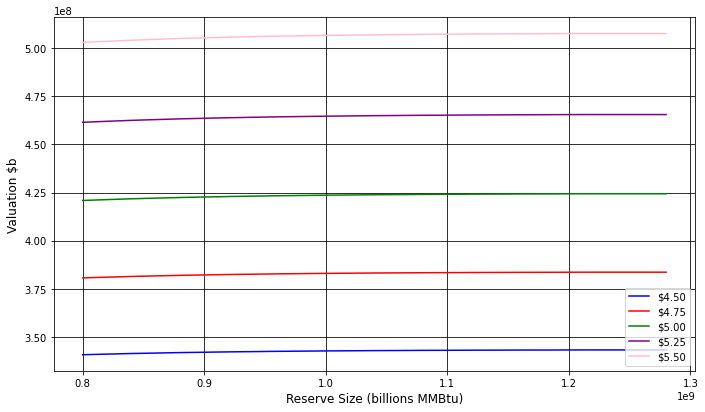

In [5]:
opt_surface_ex1 = temp_node[1,13,:,1,1]
opt_surface_ex2 = temp_node[1,14,:,1,1]
opt_surface_ex3 = temp_node[1,15,:,1,1]
opt_surface_ex4 = temp_node[1,16,:,1,1]
opt_surface_ex5 = temp_node[1,17,:,1,1]


fig = plt.gcf()
fig.set_size_inches(11.5, 6.5)
plt.plot(s0_grid,opt_surface_ex1,color="blue")
plt.plot(s0_grid,opt_surface_ex2,color="red")
plt.plot(s0_grid,opt_surface_ex3,color="green")
plt.plot(s0_grid,opt_surface_ex4,color="purple")
plt.plot(s0_grid,opt_surface_ex5,color="pink")

plt.xlabel('Reserve Size (billions MMBtu)', fontsize=12)
plt.ylabel('Valuation $b', fontsize=12)
plt.legend(["$4.50","$4.75","$5.00","$5.25","$5.50"], loc ="lower right")
plt.grid(color="black")

plt.savefig('/Users/joe/Dropbox/PhD/Writing/TeX/Charts/valuationtest.png', dpi=400)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

s0_grid, P_grid = np.meshgrid(s0_grid,P_grid)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(s0_grid, P_grid, opt_surface_1)
ax.set_zlim(0, 13000000)

plt.show()